In [2]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

# Data augmentation
We need data augmentation to multiply our data in order to over reduce the effect of data imbalance. Because of our problem, we can only use some of the augmentation methods for example shearing, shifting, rolling, cropping, rotating other than (90, 180, -90) can cause label change. So we can only use flipping and rotating with (90, -90, 180).

However, this operations has same results for some configurations. Because of that using 90* rotation and flipping horizontally and vertically will give us 8x data.

## Dataset class modification
To be able to use the same dataset class with data augmentation we need to inform the class to do a data augmentation that we want. There will be 3 different augmentation as we decided above. We can use the data length and index for conveying that information. As a result of the augmentations we will have 8x data if we keep the old length as limit and multiply our length, we can use the indexes to apply augmentations.

After dividing the wanted index will give us a number in between 0 and 7 and we can use the bits of them to find which operation to do thus we need 3 flag to check the operation.

In [3]:
class CardImageDataset():
    def __init__(self, root_dir='F:\my proj\lincode', header_file='gicsd_labels.csv', image_dir='images'):
        '''
        root_dir: location of the dataset dir
        header_file: location of the dataset header in the dataset directory
        image_dir: location of the images
        '''
        header_path = os.path.join(root_dir,header_file)
        self.data_header = pd.read_csv(header_path, sep=', ', engine='python')
        self.image_dir = os.path.join(root_dir,image_dir)
        
        self.header_info, self.image_files, self.classes = self.header_info_extractor()
        
        self.limit = len(self.image_files)
        self.length = len(self.image_files) * 8
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, idx):
        hflip, vflip, rotate = self.data_augmentations(idx)
        idx = idx % self.limit 
        gray_image = self.load_image(self.image_files[idx])
        label = torch.LongTensor([self.header_info[idx,-1]])
        if hflip:
            gray_image = torch.flip(gray_image, dims=[1])
        if vflip:
            gray_image = torch.flip(gray_image, dims=[2])
        if rotate:
            gray_image = torch.rot90(gray_image, 1, dims=[2,1])
        return {'image': gray_image, 'label': label}

    def data_augmentations(self, idx):
        places = idx // self.limit
        hflip = bool(places & 1)
        places = places >> 1
        vflip = bool(places & 1)
        places = places >> 1
        rotate = bool(places & 1)
        return hflip, vflip, rotate
        
    def load_image(self, image_file):
        '''
        image_file: file name of the image in dataset
        return: blue channel of the loaded image
        '''
        file_path = os.path.join(self.image_dir, image_file)
        frame = cv2.imread(file_path)[:,:,0].astype(np.float32)
        frame = torch.from_numpy(frame)
        frame /= 255
        frame = torch.unsqueeze(frame, dim=0)
        frame = transforms.functional.normalize(frame,
                                        mean=[0.406],
                                        std=[0.225])
        return frame
    
    def header_info_extractor(self):
        image_files = list(self.data_header['IMAGE_FILENAME'].values)
        labels = self.data_header['LABEL'].values.astype(str)
        label_set = sorted(list(set(labels)))

        new_data_block = []
        for row in zip(image_files, labels):
            file_name = row[0].split('_')
            new_data_block.append(file_name[1:-1] + [row[1]])    
        new_data_block = np.array(new_data_block)

        # chaning labels to numbers can help data processing
        for i, x in enumerate(label_set):
            new_data_block[new_data_block[:,-1] == x,-1] = i
        new_data_block = new_data_block.astype(np.int)
        return new_data_block, image_files, label_set
    
    def decode_label(self, label):
        return self.classes[label]

In [4]:
dataset = CardImageDataset(root_dir='F:\my proj\lincode', header_file='gicsd_labels.csv', image_dir='images')
print(len(dataset))

6400


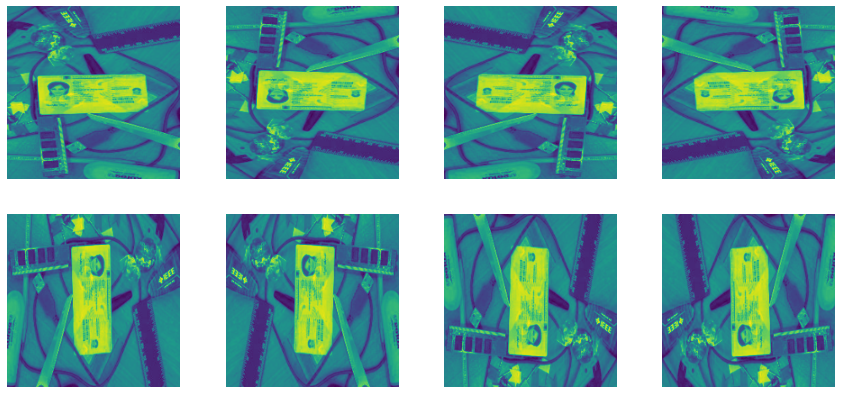

In [5]:
plt.rcParams["figure.figsize"] = 15, 7
limit = dataset.limit

i = 1
d = 1
for k in range(8):
    idx = i + limit * k
    test_image = dataset[idx]['image']
    plt.subplot(2,4,d); plt.imshow(test_image[0]); plt.axis('off')
    d += 1

# Data splits
Now, we can generate some data but if we use all the data this will worsen the issiu. We need to choose which ones to use so we need to sample from our orginal dataset and then use those indeces to get the data we want.

In [6]:
hi = dataset.header_info
print(hi.shape)

(800, 3)


In [7]:
labels, l_counts = np.unique(hi[:,2], return_counts=True)
print(labels)
print(dataset.classes)
print(l_counts)

[0 1 2]
['FULL_VISIBILITY', 'NO_VISIBILITY', 'PARTIAL_VISIBILITY']
[646  31 123]


In [8]:
backgrounds, bg_counts = np.unique(hi[:,1], return_counts=True)
print(backgrounds)
print(bg_counts)

[0 1 2 3 4 5 6 7 8 9]
[100 100  50 100  50 100  50 100  50 100]


In [9]:
cards, c_counts = np.unique(hi[:,0], return_counts=True)
print(cards)
print(c_counts)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16]


We need to take from each sample at least one if there is, for test and validation sets

In [10]:
vis_mask = tuple(hi[:,2] == 1)
backgrounds, bg_counts = np.unique(hi[vis_mask,1], return_counts=True)
print('no visibility backgrounds')
print(backgrounds)
print(bg_counts)

vis_mask = tuple(hi[:,2] == 2)
backgrounds, bg_counts = np.unique(hi[vis_mask,1], return_counts=True)
print('partial visibility backgrounds')
print(backgrounds)
print(bg_counts)

no visibility backgrounds
[6 7]
[ 2 29]
partial visibility backgrounds
[0 1 2 3 5 6 7 9]
[ 1  9  7 18  6 42 38  2]


In [11]:
vis_mask = tuple(hi[:,2] == 2)
cards, c_counts = np.unique(hi[vis_mask,0], return_counts=True)
print('partial visibility ids')
print(cards)
print(c_counts, 'min: ',np.min(c_counts))

vis_mask = tuple(hi[:,2] == 0)
cards, c_counts = np.unique(hi[vis_mask,0], return_counts=True)
print('partial visibility ids')
print(cards)
print(c_counts, 'min: ',np.min(c_counts))

partial visibility ids
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50]
[1 2 3 2 2 3 2 3 5 2 3 2 1 2 1 4 3 2 1 3 1 2 2 3 2 3 3 3 3 2 3 1 2 3 2 3 3
 7 2 2 3 2 1 4 3 3 3 2 3] min:  1
partial visibility ids
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
[14 13 13 14 13 13 14 12 11 13 13 13 14 13 14 11 12 13 14 15 12 14 14 13
 13 14 13 12 12 12 14 12 14 13 12 13 13 13  9 13 14 12 14 14 11 13 13 13
 13 12] min:  9


# Train splits creation
We can give 10\% of our data to test set to keep a bit more data for training

In [12]:
print(np.ceil(646 * 0.1))
print(np.ceil(31 * 0.1))
print(np.ceil(123 * 0.1))
test_indexes = []
train_indexes = []
val_indexes = []

65.0
4.0
13.0


# No visibility class

In [13]:
mask = tuple(np.logical_and(hi[:,2]==1, hi[:,1]==6))
test_indexes.append(np.where(mask)[0][0])
train_indexes.append(np.where(mask)[0][1])

mask = tuple(np.logical_and(hi[:,2]==1, hi[:,1]!=6))
indexes = np.where(mask)[0]
choices = np.random.choice(len(indexes), 3, replace=False)
test_indexes += list(indexes[choices])
indexes = np.delete(indexes, choices)

choices = np.random.choice(len(indexes), 4, replace=False)
val_indexes += list(indexes[choices])
indexes = np.delete(indexes, choices)

train_indexes += list(indexes)
print('test: ', len(test_indexes), 'val: ', len(val_indexes), 'train: ', len(train_indexes))

test:  4 val:  4 train:  23


# Partial visibility class

In [14]:
mask = tuple(hi[:,2]==2)
indexes = np.where(mask)[0]
choices = np.random.choice(len(indexes), 13, replace=False)
test_indexes += list(indexes[choices])
indexes = np.delete(indexes, choices)

choices = np.random.choice(len(indexes), 13, replace=False)
val_indexes += list(indexes[choices])
indexes = np.delete(indexes, choices)

train_indexes += list(indexes)
print('test: ', len(test_indexes), 'val: ', len(val_indexes), 'train: ', len(train_indexes))

test:  17 val:  17 train:  120


#### Before full visibility class we can do the data augmentation here

In [15]:
test_temp = np.array(test_indexes.copy())
val_temp = np.array(val_indexes.copy())
train_temp = np.array(train_indexes.copy())
for i in range(2, 8):
    test_indexes += list(test_temp * i)
    val_indexes += list(val_temp * i)
    train_indexes += list(train_temp * i)
print('test: ', len(test_indexes), 'val: ', len(val_indexes), 'train: ', len(train_indexes))

test:  119 val:  119 train:  840


In [16]:
mask = tuple(hi[:,2]==0)
indexes = np.where(mask)[0]
choices = np.random.choice(len(indexes), 65, replace=False)
test_indexes += list(indexes[choices])
indexes = np.delete(indexes, choices)

choices = np.random.choice(len(indexes), 65, replace=False)
val_indexes += list(indexes[choices])
indexes = np.delete(indexes, choices)

train_indexes += list(indexes)
print('test: ', len(test_indexes), 'val: ', len(val_indexes), 'train: ', len(train_indexes))

test:  184 val:  184 train:  1356


In [17]:
np.save('F:/my proj/lincode/artifacts/test_indexes.npy', np.array(test_indexes))
np.save('F:/my proj/lincode/artifacts/val_indexes.npy', np.array(val_indexes))
np.save('F:/my proj/lincode/artifacts/train_indexes.npy', np.array(train_indexes))